# Imports

In [104]:
# import networkx as nx
# import pandas as pd
import numpy as np
import os
# import sys
# import re
# import argparse
# import itertools
import glob as glob
# import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, deque


from plotnine import *

notebook_dir = os.getcwd()

# Read Data

In [105]:
def get_files_from_directory(directory_name, notebook_dir):
    """
    Retrieves a dictionary of files and their corresponding paths from a given directory.

    Args:
        directory_name (str): The name of the target directory (e.g., 'modern').
        notebook_dir (str): The base directory where the notebook is located.

    Returns:
        dict: A dictionary where keys are subdirectory names and values are dictionaries
              containing file names and their respective paths.
    """
    # Set the path to the target directory (assumed to be one level up)
    target_dir = os.path.abspath(os.path.join(notebook_dir, "..", directory_name))

    # Get a list of all directories in the target directory
    sub_dirs = [d for d, _, _ in os.walk(target_dir) if d != target_dir]

    # Dictionary to store files and file paths
    files = {}

    for d in sub_dirs:
        last_dir_name = os.path.basename(d)  # Get the last directory name

        # Get a list of files in the directory
        file_list = os.listdir(d)

        # Skip empty directories
        if not file_list:
            continue

        # Store both file names and full file paths
        files[last_dir_name] = {
            "files": file_list,
            "file_paths": d,
        }

    return files

modern_files = get_files_from_directory("modern", notebook_dir)
historic_files = get_files_from_directory("historic", notebook_dir)

# Process files

In [106]:
def get_pi_and_collaborators(data):
    pi_collabs = {}

    # Ensure "pi" exists and is a list; otherwise, use an empty list
    pi_list = data.get("pi")

    if not isinstance(pi_list, list):  # If "pi" is not a list, set it to an empty list
        pi_list = []

    for pi in pi_list:
        inst_id = pi.get("inst_id", "Unknown Inst")  # Handle missing keys
        pi_dept_name = pi.get("pi_dept_name", "Unknown Dept")
        pi_collabs[inst_id] = pi_dept_name

    return pi_collabs


def get_institute_name_and_id(data, institutions):
    inst_id = data.get("inst", {}).get("inst_id")  # Handle missing keys safely
    inst_name = data.get("inst", {}).get("inst_name")

    if inst_id and inst_id not in institutions:  # Only add if it's missing
        institutions[inst_id] = inst_name

    return institutions

In [107]:
def process_files(files, collabs, institutions):
    for key, value in files.items():  # Iterating over dictionary

        # Ensure "files" key is a list before slicing
        file_list = value.get("files", [])

        for file in file_list:  # Slice safely if it's a list

            json_file_path = os.path.join(value["file_paths"], file)

            try:
                with open(json_file_path, "r") as f:
                    data = json.load(f)

                # Process institute information
                institutions = get_institute_name_and_id(data, institutions)

                # Process PI collaborations
                pi_collabs = get_pi_and_collaborators(data)

                # Ignore PIs with only one entry
                if len(pi_collabs) > 1:

                    if key not in collabs:
                        collabs[key] = {}
                    collabs[key][file] = pi_collabs

            except (FileNotFoundError, json.JSONDecodeError) as e:
                print(f"Error reading {json_file_path}: {e}")

    return collabs, institutions

mordern_collabs = {}
historic_collabs = {}
institutions = {}

mordern_collabs, institutions = process_files(modern_files, mordern_collabs, institutions)
historic_collabs, institutions = process_files(historic_files, historic_collabs, institutions)

In [108]:
print((institutions))
print((mordern_collabs))

{'0031708000': 'Oklahoma State University', '4003554000': 'Gordon Research Conferences', '7203585001': 'AUGRAY LLC', '0010819000': 'Arizona State University', '0032235000': 'University of Oregon Eugene', 'P270067958': 'Favela, Alonso', '0028373000': 'SUNY at Buffalo', 'P270067725': 'Patterson, Jeremy R', '0011395001': 'California State University-Long Beach Foundation', '4000600000': 'American Geophysical Union', '0096354000': 'Florida International University', '0014456000': 'Georgetown University', '0036525000': 'University of Houston', '0013219000': 'University of California-Santa Cruz', '0032565000': 'Drexel University', '0030320000': 'Cleveland State University', '0017756000': 'University of Illinois at Urbana-Champaign', '0034017000': 'Brown University', '0037986000': 'University of Washington', '0033290000': 'Pennsylvania State Univ University Park', '0015693000': 'Georgia Tech Research Corporation', '5300004339': 'Wepan Inc', '0023879000': 'University of Minnesota-Twin Cities',

# Get Adjacency Lists

In [ ]:
def build_collaboration_network(modern_collabs, start_uni=None):
    # Use defaultdict to avoid explicit key checks
    collab_network = defaultdict(set)

    # Find first university if not provided
    if not start_uni:
        first_key = next(iter(modern_collabs))
        first_file = next(iter(modern_collabs[first_key]))
        start_uni = next(iter(modern_collabs[first_key][first_file]))

    # Track visited nodes to avoid redundant processing
    visited = {start_uni}
    queue = deque([start_uni])

    while queue:
        current_uni = queue.popleft()

        # Process each repository once
        for repo_files in modern_collabs.values():
            # Process each file in repository
            for file_collabs in repo_files.values():
                if current_uni in file_collabs:
                    # Add all collaborators at once
                    collaborators = set(file_collabs.keys()) - {current_uni}
                    collab_network[current_uni].update(collaborators)

                    # Add unvisited collaborators to queue
                    unvisited = collaborators - visited
                    queue.extend(unvisited)
                    visited.update(unvisited)

    return dict(collab_network)

modern_collabs_list = build_collaboration_network(mordern_collabs)
historic_collabs_list = build_collaboration_network(historic_collabs)
print(len(modern_collabs_list))
print(len(historic_collabs_list))

3262
2650


# Plot Adjacency Lists

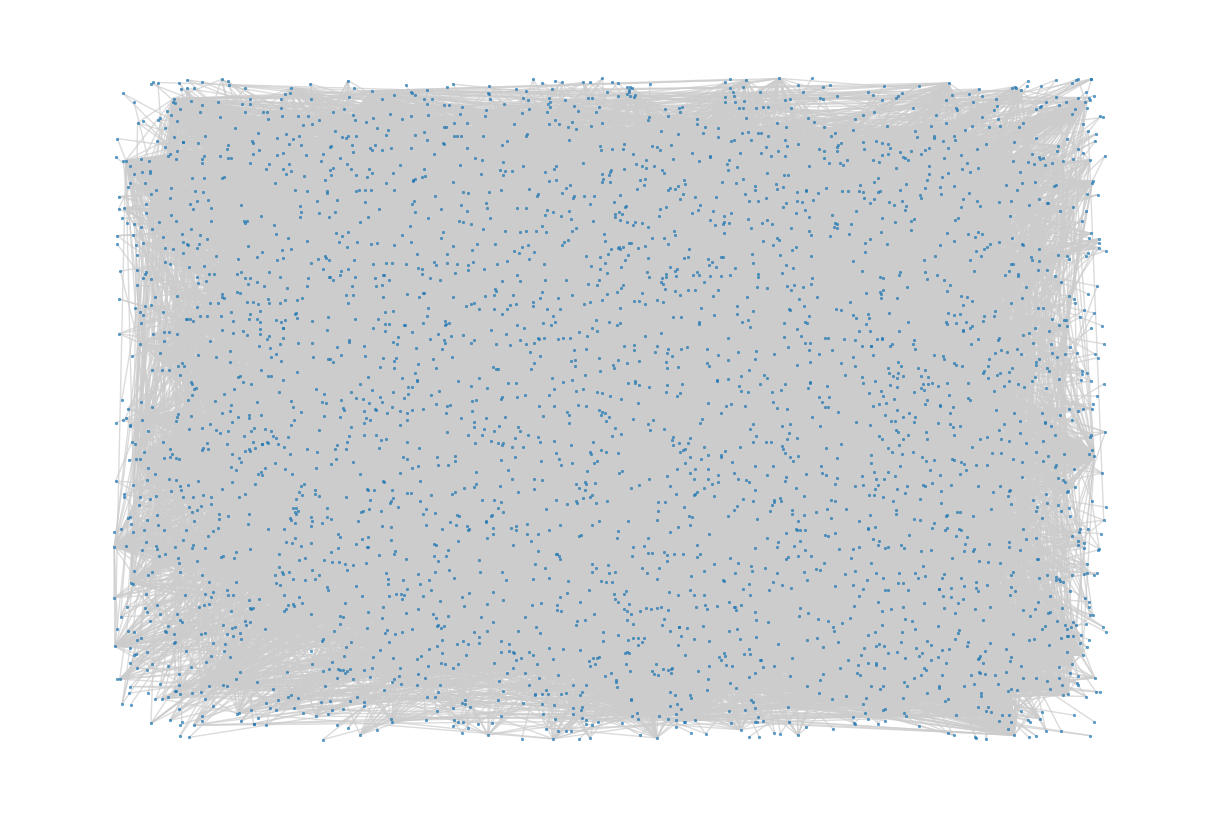

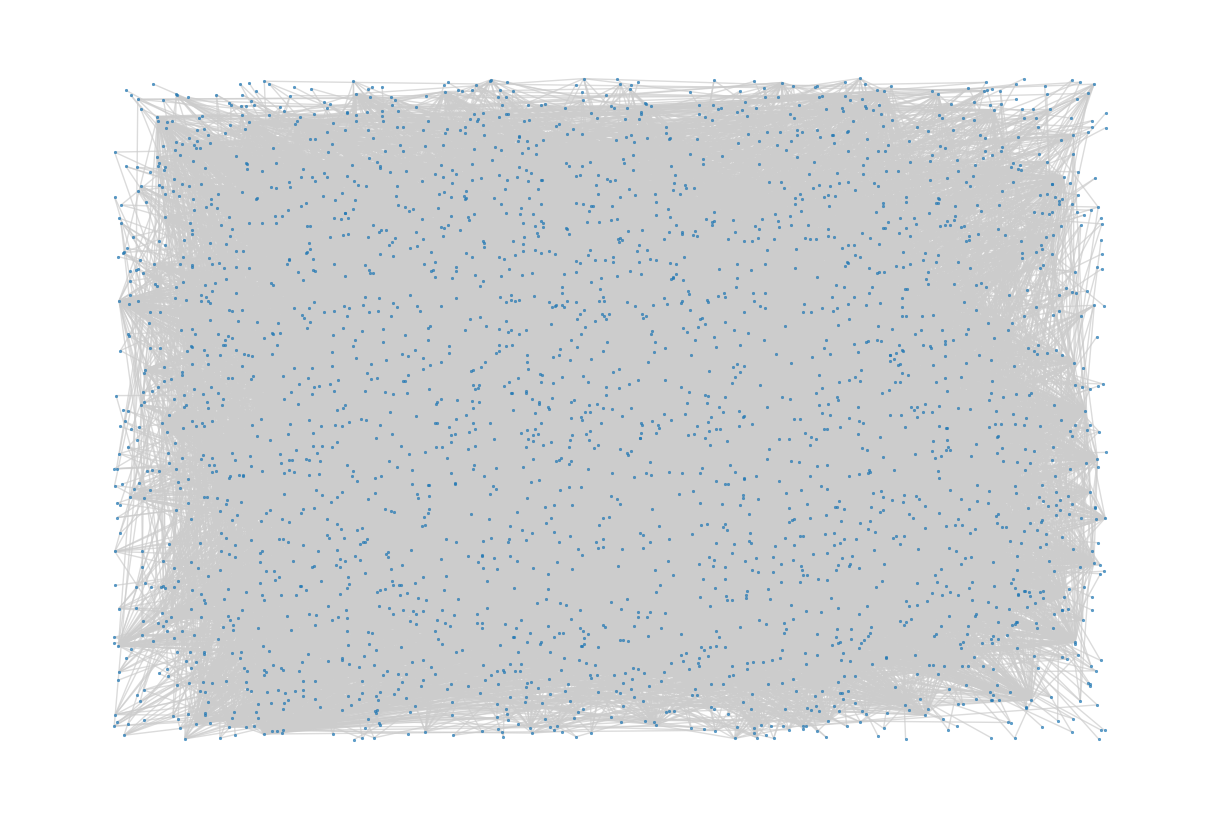

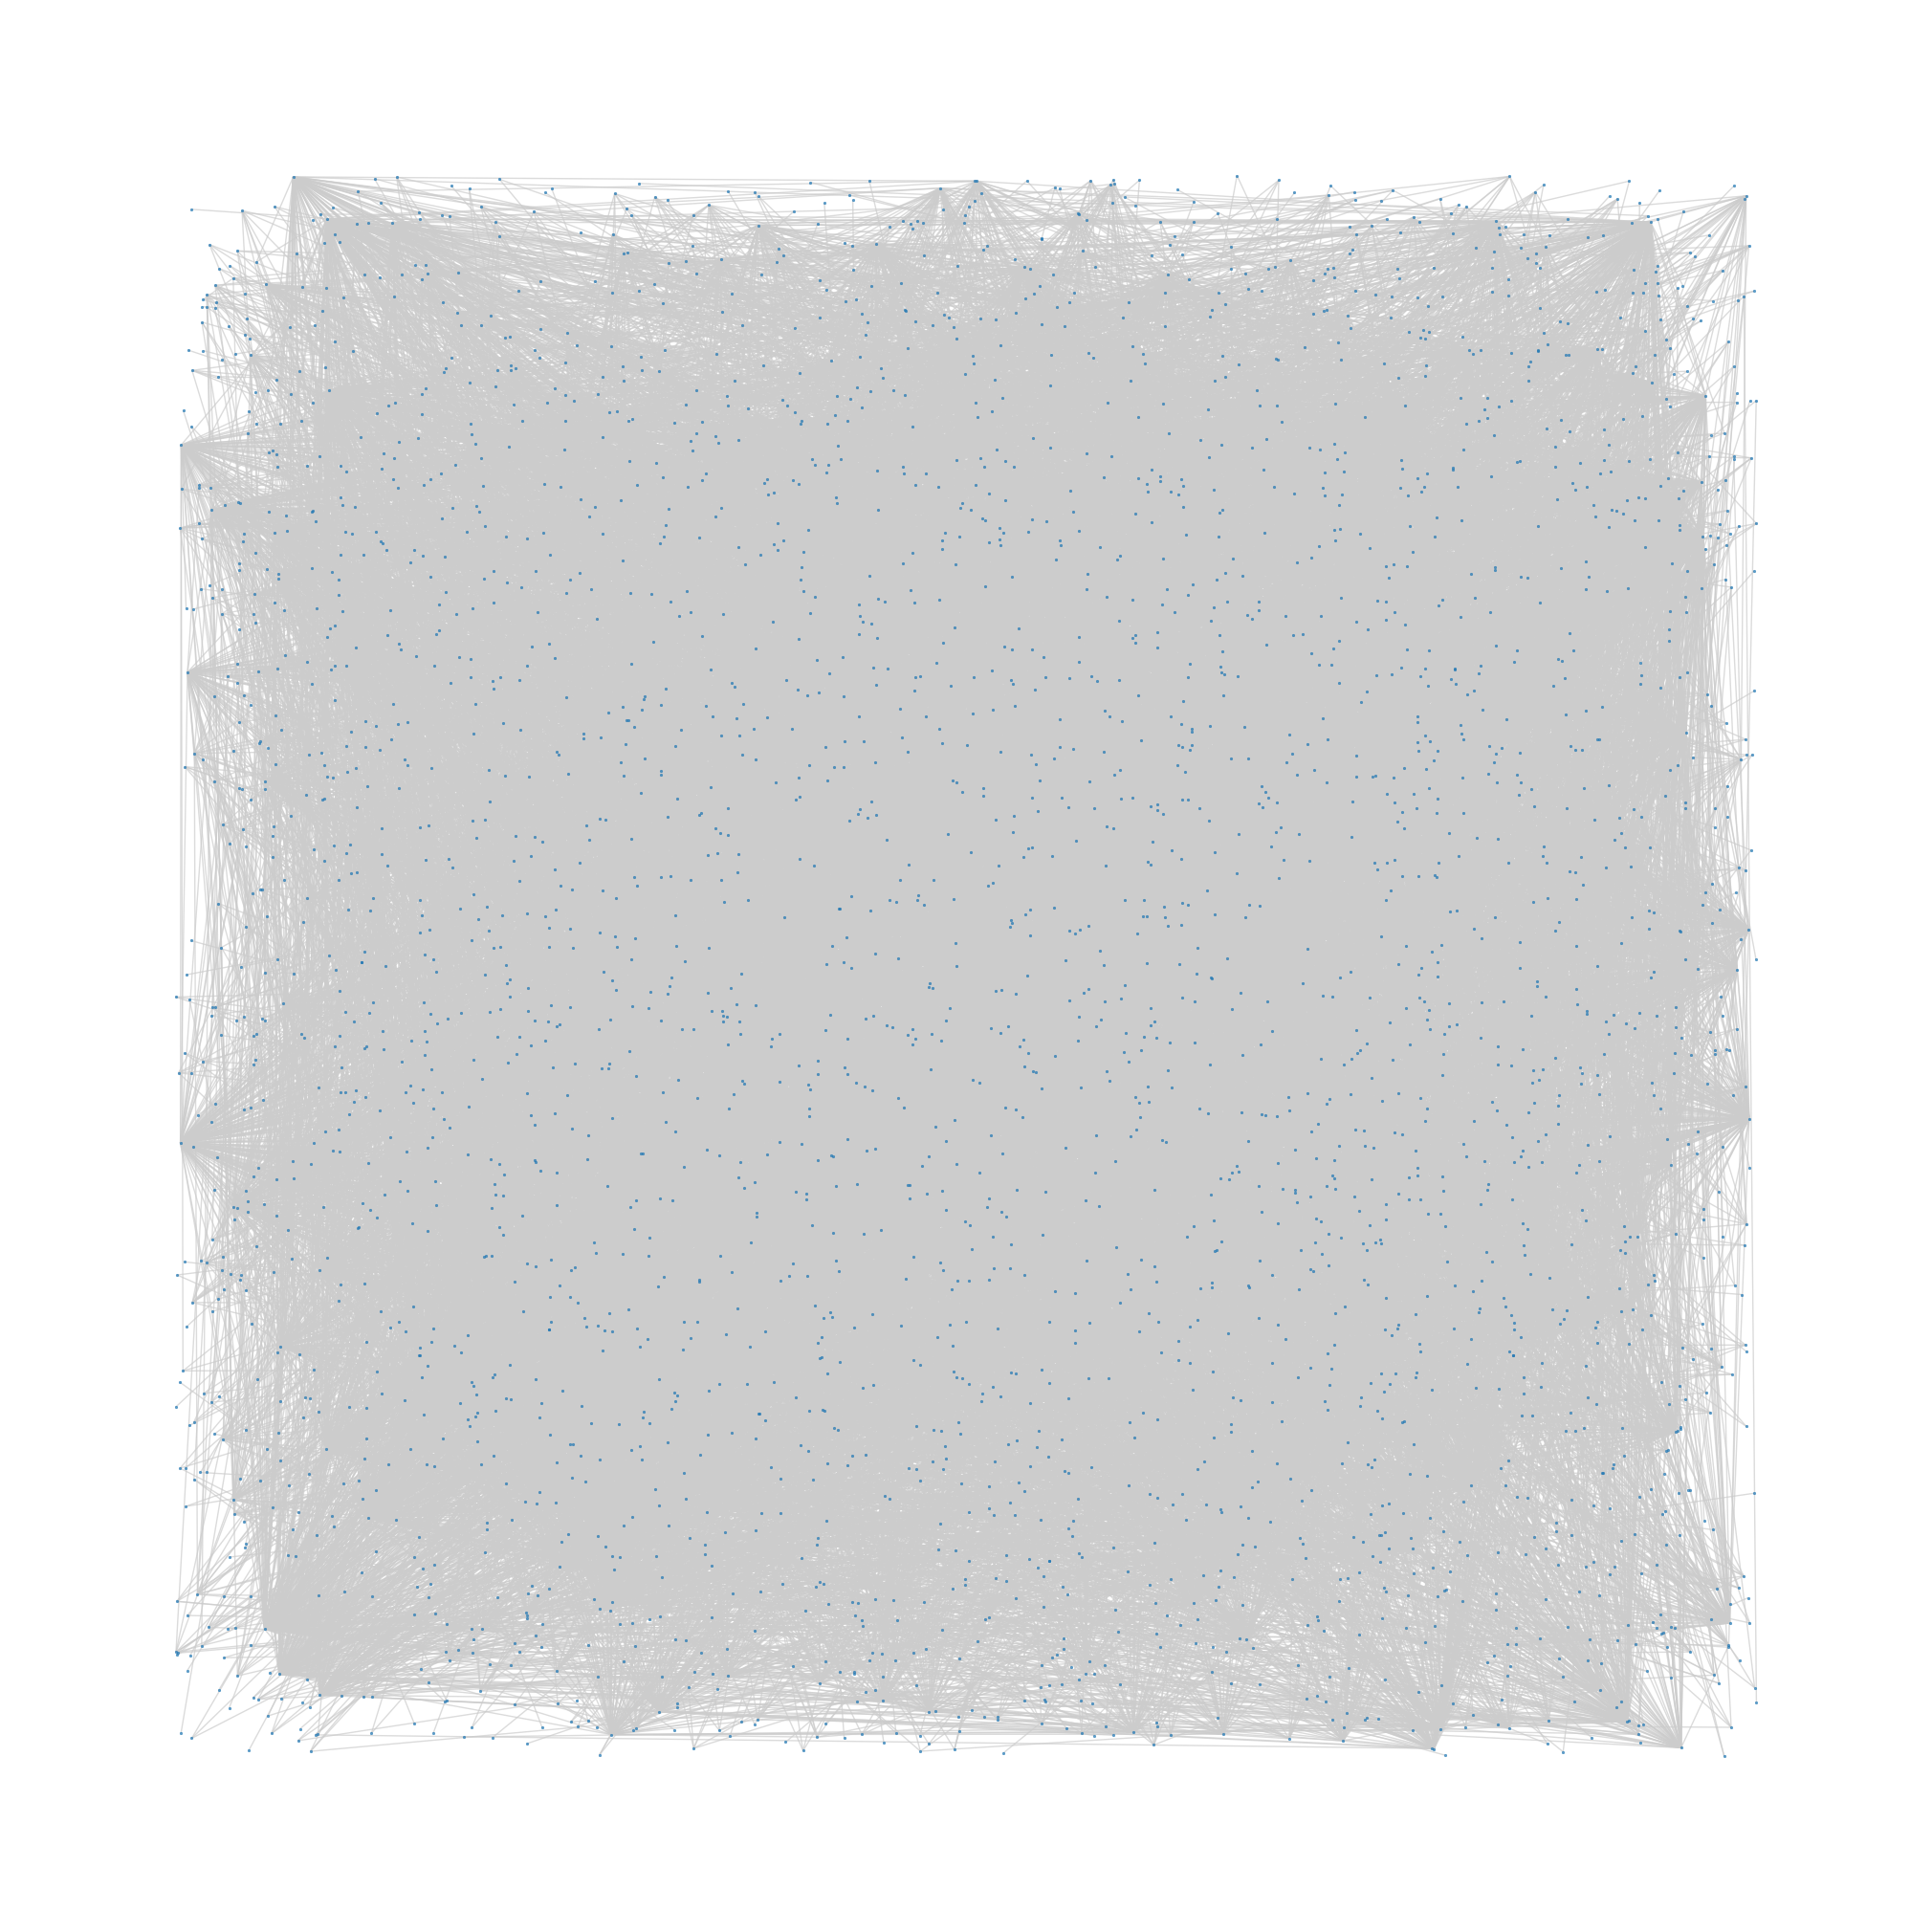

In [ ]:
def visualize_collaboration_network(collab_dict, figsize=(12, 8), layout="spring"):
    """
    Create and visualize a network graph from collaboration data with optimized performance.

    Args:
        collab_dict: Dictionary of collaborations
        figsize: Tuple for figure size
        layout: String specifying layout algorithm ('spring', 'kamada_kawai', etc.)
    """
    # Create graph from edge list for better performance
    edges = [
        (pi, collab)
        for pi, collabs in collab_dict.items()
        if pi is not None
        for collab in collabs
        if collab is not None
    ]

    G = nx.Graph()
    G.add_edges_from(edges)

    # Configure plot
    plt.figure(figsize=figsize)

    # Choose layout based on graph size
    if len(G) > 1000:
        pos = nx.random_layout(G)  # Fastest layout
    elif layout == "spring":
        pos = nx.spring_layout(G, k=1 / np.sqrt(len(G)), iterations=50)
    else:
        pos = getattr(nx, f"{layout}_layout")(G)

    # Optimize node appearance
    node_size = min(3000 / np.sqrt(len(G)), 3)  # Scale node size based on graph size

    # Draw with optimized settings
    nx.draw(
        G,
        pos=pos,
        node_size=node_size,
        node_color="#1f77b4",
        edge_color="#cccccc",
        alpha=0.7,
        with_labels=False,
        linewidths=0.5,
    )

    plt.axis("off")
    return G, plt.gcf()


# create subplots
G_modern, fig = visualize_collaboration_network(modern_collabs_list)
G_historic, fig = visualize_collaboration_network(historic_collabs_list)

# For extremely large graphs
G, fig = visualize_collaboration_network(
    modern_collabs_list, layout="random", figsize=(20, 20)  # Fastest layout
)

# Get Statisticts

In [215]:
# get mean degree of the graph
mean_degree_modern = np.mean([d for n, d in G_modern.degree()])
print(mean_degree_modern)

mean_degree_historic = np.mean([d for n, d in G_historic.degree()])
print(mean_degree_historic)


8.402330573443729
8.058912386706949
